In [432]:
import numpy as np

In [433]:
def read_csv(file):
    objects = np.genfromtxt(file, delimiter=',',dtype=float)
    objects = objects[1:,2:]
    objects.sort()
    total_space = 0.0
    for obj in objects:
        total_space += obj[0]*obj[1]*obj[2]

    return objects, total_space

In [434]:
# Input: nombre objectes que es volen crear, valors minim i maxim de les mides
# Output: objects (shape=(num_objects, 3)), total espai que ocupen

def init_objects(num_objects, min_val, max_val):
    
    dim = 3

    #Intenta crear una distribució no-uniforme, per a crear "clusters"
    o1 = np.random.randint(min_val, min_val+(max_val-min_val)//4, size=(num_objects*3//7 * dim))
    o2 = np.random.randint(max_val//4, min_val+(max_val-min_val)*3//4, size=(num_objects//7 * dim))
    o3 = np.random.randint(max_val*3//4, min_val+(max_val-min_val), size=(dim*num_objects-len(o1)-len(o2)))

    objects = np.concatenate([o1,o2,o3])
    #np.random.shuffle(objects)
    
    objects = objects.reshape((num_objects, dim))
    objects.sort()

    total_space = 0.0  #espai total dels objectes
    for obj in objects:
        s = obj[0]*obj[1]
        if dim==3:
            s *= obj[2]
        total_space += s

    return objects, total_space


In [435]:
#Input: nombre de caixes a inicialitzar, llista d'objectes
#Output: es trien mides de caixes iguals que mides d'alguns objectes (random)
#OBS// una de les caixes ha de ser de mida màxima (que pugui contenir qualsevol objecte)

def init_boxes(num_boxes, objects):
    
    box_sizes = []
    box_sizes.append( tuple(np.max(objects, axis=0)) )  #aquesta caixa pot contenir qualsevol objecte

    idx = np.random.choice(len(objects), size=num_boxes-1, replace=False)

    for i in idx:
        box_sizes.append( tuple(objects[i]) )
    
    return np.sort( np.array(box_sizes) )


In [436]:
### Input: llista d'objectes, una assignació de caixes a cada objecte
# Com a màxim s'usen 'NUM_CAIXES' caixes (pot ser menys)
### Output: una llista de tripletes amb les mides de les caixes

def compute_sizes(objects, box_assignment, num_boxes):
    if len(objects[0])==3:
        sizes = [(0,0,0)] * num_boxes   #sizes[k] = (X1,X2,X3)  => mida caixa 'k'
    else:
        sizes = [(0,0)] * num_boxes

    for box in range(num_boxes):
        object_indexes = np.where(np.array(box_assignment)==box)[0]

        if list(object_indexes):
            sizes[box] = tuple(np.max( objects[object_indexes], axis=0))
    
    #assert sum([s[0]*s[1]*s[2] == 0 for s in sizes]) == 0
    return np.sort( np.array(sizes) )


In [437]:
### Input: llista d'objectes i llista de mides de caixes
### Output: vector d'assignació per a cada objecte.

def compute_assignment(objects, box_sizes):

    assignment = [None] * len(objects)

    for obj_id, obj in enumerate(objects):

        min_space = float("inf")

        for box_id, box in enumerate(box_sizes):
            if (np.array(box) == 0).all():
                #print("Caixa sense mesura (compute_assignment")
                continue

            if len(box)==3:
                assert box[0] <= box[1] <= box[2]
                assert obj[0] <= obj[1] <= obj[2]
                box_space = box[0]*box[1]*box[2]
                fits = obj[0]<=box[0] and obj[1]<=box[1] and obj[2]<=obj[2]
            elif len(box)==2:
                assert box[0] <= box[1]
                assert obj[0] <= obj[1]
                box_space = box[0]*box[1]
                fits = obj[0]<=box[0] and obj[1]<=box[1]
            #print("    ", box, ":", box_space, "fits:", fits)
            if fits and box_space < min_space:
                assignment[obj_id] = box_id 
                min_space = box_space

    #print(assignment)
    assert sum([s is None for s in assignment]) == 0
    return np.array(assignment)
   

In [438]:
### Comprova si el input donat és més òptim que la millor solució actual
### Si cal, actualitza les variables globals per a guardar la millor solució

def check_if_best(box_assignment, box_sizes):

    space = 0.0  #espai buit en el total de caixes
    
    for box, size in enumerate(box_sizes):
        if size is not None:
            a = np.sum(box_assignment==box)
            if len(size)==3:
                space += a*size[0]*size[1]*size[2]
            elif len(size)==2:
                space += a*size[0]*size[1]



    global BEST_SIZES
    global BEST_SPACE
    global BEST_ASSIGNMENT

    if space < BEST_SPACE:

        BEST_SPACE = space
        BEST_ASSIGNMENT = tuple(box_assignment)
        BEST_SIZES = box_sizes


In [439]:
"""K-MEANS MAIN FUNCTION"""
### INICIALITZACIÓ DE MIDES DE CAIXES ###

###  PARAMETRES
DIM = 3
NUM_OBJECTS = 1000
NUM_BOXES = 5
NUM_ITER = 15
MIN_VAL = 10
MAX_VAL = 100
np.random.seed(1234)

###  GLOBAL VARIABLES
BEST_SPACE = float('inf')  #espai total de caixes
BEST_SIZE = None
BEST_ASSIGNMENT = None

#Inicialitzem els objectes
OBJECTS, TOTAL_SPACE = init_objects(NUM_OBJECTS, MIN_VAL, MAX_VAL)
#OBJECTS, TOTAL_SPACE = read_csv("objectes.csv")
#NUM_OBJECTS = len(OBJECTS)

#Executem l'algorisme NUM_ITER vegades
for i in range(NUM_ITER):

    if i%10 == 0:
        print("i=", i)

    #Comencem amb assignació aleatoria de mides de caixes
    box_sizes = init_boxes(NUM_BOXES, OBJECTS)

    i = 0
    convergence = False  #convergence: quan no s'actualitzin les assignacions (minim local)
    while not convergence:

        #Calcul de mides de caixes amb assignació actual
        #old_sizes = box_sizes.copy()
        box_assignment = compute_assignment(OBJECTS, box_sizes)

        #Calcul de mides de caixes segon assignacions actuals
        #print("EEEEE", box_sizes)
        new_sizes = compute_sizes(OBJECTS, box_assignment, NUM_BOXES)
        convergence = (np.array(box_sizes) == np.array(new_sizes)).all()
        i += 1
        if convergence:
            #print("iters before convergence =", i)
            pass
        
        print_ = False
        if print_:
            print("current assignment =", box_assignment)
            print("old box_sizes =", box_sizes)
            print("new box_sizes =", new_sizes)
            print("convergece? = ", convergence, "(",i,")")
            print()
            
        box_sizes = new_sizes.copy()

        check_if_best(box_assignment, box_sizes)


i= 0
i= 10


In [440]:
import matplotlib.pyplot as plt

def plot(objects, box_assignment, box_sizes, display_info=False):

    colors = ('b','g','r','c','m','y','k','w')
    assert len(colors) >= len(box_sizes)  #afegir més colors!

    box_assignment = np.array(box_assignment)

    for box_id in range(len(box_sizes)):
        c = colors[box_id]
        objs = objects[box_assignment==box_id]
        if display_info:
            print("box_id:",box_id,"  size:",best_sizes[box_id],"  num_objs:",len(objs),"  min_obj:",np.min(objs,axis=0),"  max_obj:",np.max(objs,axis=0))
        plt.scatter(objs[:,0], objs[:,1], marker=".", c=c)
        a,b = box_sizes[box_id]
        plt.plot((0,a), (b,b), color=c)
        plt.plot((a,a), (0,b), color=c)
        
    plt.show()

#plot(OBJECTS, BEST_ASSIGNMENT, BEST_SIZES)

In [441]:
for id, o in enumerate(OBJECTS):
    if o[0]==26 and o[1]==30:
        print(id, o)

560 [26 30 75]


103


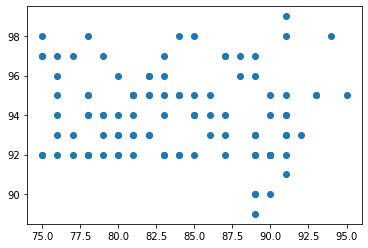

In [442]:
oo = OBJECTS[np.array(BEST_ASSIGNMENT)==0]
print(len(oo))
plt.scatter(oo[:,0], oo[:,1])

In [443]:
print("####   BEST SOLUTION   ####")
print("BEST_SIZES = ", BEST_SIZES[:5])
print("Filled Space[%] = ", round(TOTAL_SPACE/BEST_SPACE*100, 2),"%")
if len(OBJECTS[0])==3:
    unused_boxes = sum([(box==(0,0,0)).all() for box in BEST_SIZES])
else:
    unused_boxes = sum([(box==(0,0)).all() for box in BEST_SIZES])
print("Unused boxes = {} ({})".format(unused_boxes, NUM_BOXES))
print("####                   ####")

print("Num objects = ", NUM_OBJECTS)
for i in range(NUM_BOXES):
    print("box", i, ":", np.sum( np.array(BEST_ASSIGNMENT)==i), "objects;   size = ", BEST_SIZES[i])

####   BEST SOLUTION   ####
BEST_SIZES =  [[95 99 99]
 [88 91 99]
 [44 56 76]
 [17 18 31]
 [83 86 99]]
Filled Space[%] =  67.56 %
Unused boxes = 0 (5)
####                   ####
Num objects =  1000
box 0 : 103 objects;   size =  [95 99 99]
box 1 : 157 objects;   size =  [88 91 99]
box 2 : 382 objects;   size =  [44 56 76]
box 3 : 132 objects;   size =  [17 18 31]
box 4 : 226 objects;   size =  [83 86 99]


In [444]:
print(TOTAL_SPACE)
print(BEST_SPACE)

305972491.0
452863741.0


In [445]:
print("OBJECT_size  -->  BOX_size")
i = 0
for box, obj in zip(BEST_ASSIGNMENT,OBJECTS):
    box_size = BEST_SIZES[box]
    print(obj, " ---> ", box_size)
    
    i += 1
    if i > 20:
        break

OBJECT_size  -->  BOX_size
[16 25 29]  --->  [44 56 76]
[22 30 31]  --->  [44 56 76]
[19 25 27]  --->  [44 56 76]
[21 22 26]  --->  [44 56 76]
[15 19 26]  --->  [44 56 76]
[25 26 28]  --->  [44 56 76]
[12 15 22]  --->  [17 18 31]
[13 16 17]  --->  [17 18 31]
[10 19 21]  --->  [44 56 76]
[13 21 26]  --->  [44 56 76]
[12 22 29]  --->  [44 56 76]
[11 21 29]  --->  [44 56 76]
[21 24 27]  --->  [44 56 76]
[17 20 29]  --->  [44 56 76]
[21 24 27]  --->  [44 56 76]
[10 23 30]  --->  [44 56 76]
[15 22 27]  --->  [44 56 76]
[15 23 30]  --->  [44 56 76]
[18 19 26]  --->  [44 56 76]
[16 22 22]  --->  [44 56 76]
[25 27 29]  --->  [44 56 76]


In [446]:
BEST_SIZES

array([[95, 99, 99],
       [88, 91, 99],
       [44, 56, 76],
       [17, 18, 31],
       [83, 86, 99]])

In [447]:
BEST_ASSIGNMENT[0:5]

(2, 2, 2, 2, 2)

In [448]:
OBJECTS

array([[16, 25, 29],
       [22, 30, 31],
       [19, 25, 27],
       ...,
       [86, 95, 95],
       [85, 89, 96],
       [76, 86, 99]])

In [449]:
def find_biggest_objects(BEST_ASSIGNMENT,OBJECTS,BEST_SIZES):
  # Per tots els objectes d'un mateix assignment, retornar el que tingui norma + petita en relació a la mida de la caixa corresponent
  # Pensar un bucle que no sigui una merda com aquest
  biggest_object = []
  for i in range(NUM_BOXES):
    norms = []
    for j in range(NUM_OBJECTS):
      if BEST_ASSIGNMENT[j] == i:
        aux = OBJECTS[j] - BEST_SIZES[i]
        norms.append((j, BEST_ASSIGNMENT[j], np.linalg.norm(aux)))
    
    norms = sorted(norms, key=lambda tup: tup[2])
    biggest_object.append(norms[0])
  return biggest_object

In [450]:
### PREDICTION FUNTION

def predict_alternative_box(biggest_obj, BEST_ASSIGNMENT, OBJECTS, BEST_SIZES):
    
    obj = tuple(OBJECTS[biggest_obj[0]])
    #assert (((isinstance(obj,list) or isinstance(obj,tuple)) and len(obj)==3))
    x1, x2, x3 = sorted(list(obj))

    current_assig = biggest_obj[1]
    #current_box = BEST_SIZES[current_assig]
    #print(current_box)
    #print(current_assig)
    #sizes = np.delete(BEST_SIZES, current_assig, axis=0)
    #print(sizes)

    min_space = float("inf")
    predicted_size = None
    assigned_box = None

    for box, size in enumerate(BEST_SIZES):
        
        if box != current_assig:

          if None in size:
              continue
      
          if x1<=size[0] and x2<=size[1] and x3<=size[2]:
              space = size[0]*size[1]*size[2]

              if space < min_space:
                  min_space = space
                  predicted_size = size
                  assigned_box = box

    return assigned_box, predicted_size


In [451]:
# Reduir al màxim BEST_SIZES
def compute_new_sizes(BEST_SIZES, NEW_ASSIGNMENT):
    NEW_SIZES = np.zeros((len(BEST_SIZES), 3), dtype=int)
    NEW_SIZES[0] = BEST_SIZES[0]
    
    for i in range(1, NUM_BOXES):
      max_x1 = 0
      max_x2 = 0
      max_x3 = 0
      for j in range(NUM_OBJECTS):
          if NEW_ASSIGNMENT[j] == i:
              #print("Assignment for object", j, ":", BEST_ASSIGNMENT[j], "  |  ", i)
              #print(OBJECTS[j])
              max_x1 = max(OBJECTS[j][0], max_x1)
              max_x2 = max(OBJECTS[j][1], max_x2)
              max_x3 = max(OBJECTS[j][2], max_x3)
      
      NEW_SIZES[i] = [max_x1, max_x2, max_x3]
    
    return NEW_SIZES

In [452]:
def print_solution_stats():
      print("####   NEW SOLUTION   ####")
      print("NEW_SIZES = ", NEW_SIZES[:5])
      print("Filled Space[%] = ", round(TOTAL_SPACE/NEW_SPACE*100, 2),"%")
      if len(OBJECTS[0])==3:
          unused_boxes = sum([(box==(0,0,0)).all() for box in NEW_SIZES])
      else:
          unused_boxes = sum([(box==(0,0)).all() for box in NEW_SIZES])
      print("Unused boxes = {} ({})".format(unused_boxes, NUM_BOXES))
      print("####                   ####")

      print("Num objects = ", NUM_OBJECTS)
      for i in range(NUM_BOXES):
          print("box", i, ":", np.sum( np.array(NEW_ASSIGNMENT)==i), "objects;   size = ", NEW_SIZES[i])

In [453]:
def heuristic1():
    biggest_obj = find_biggest_objects(BEST_ASSIGNMENT,OBJECTS,BEST_SIZES)
    print("The biggest objects for each assignment are (index, assignment, distance to the box size):")
    print(biggest_obj)
    print("---------------------------------------------------------------")

    NEW_ASSIGNMENT = list(BEST_ASSIGNMENT)
    for i in range(1, len(BEST_SIZES)):
        obj = biggest_obj[i]
        old_assig = obj[1]
        old_size = BEST_SIZES[old_assig]
        new_assig, new_size = predict_alternative_box(obj, BEST_ASSIGNMENT, OBJECTS, BEST_SIZES)
        print("Current box for object", i+1, ":" , old_size, "| New box for object", i+1, ": ", new_size )
        NEW_ASSIGNMENT[obj[0]] = new_assig
    NEW_ASSIGNMENT = tuple(NEW_ASSIGNMENT)

    print("---------------------------------------------------------------")

    NEW_SIZES = compute_new_sizes(BEST_SIZES, NEW_ASSIGNMENT)

    boxes = np.zeros(NUM_BOXES, dtype=int)
    
    for i in range(NUM_OBJECTS):
        boxes[NEW_ASSIGNMENT[i]] +=1
        
    space = 0.0  #espai buit en el total de caixes

    for j in range(NUM_BOXES):
        space = space + boxes[j] * NEW_SIZES[j][0] * NEW_SIZES[j][1] * NEW_SIZES[j][2]
        
    NEW_SPACE = space

    print_solution_stats()

In [454]:
print(heuristic1())

The biggest objects for each assignment are (index, assignment, distance to the box size):
[(585, 0, 1.7320508075688772), (829, 1, 0.0), (465, 2, 0.0), (132, 3, 2.449489742783178), (827, 4, 2.23606797749979)]
---------------------------------------------------------------
Current box for object 2 : [88 91 99] | New box for object 2 :  [95 99 99]
Current box for object 3 : [44 56 76] | New box for object 3 :  [83 86 99]
Current box for object 4 : [17 18 31] | New box for object 4 :  [44 56 76]
Current box for object 5 : [83 86 99] | New box for object 5 :  [88 91 99]
---------------------------------------------------------------
####   NEW SOLUTION   ####
NEW_SIZES =  [[95 99 99]
 [88 91 99]
 [44 56 76]
 [17 18 31]
 [83 86 99]]
Filled Space[%] =  67.43 %
Unused boxes = 0 (5)
####                   ####
Num objects =  1000
box 0 : 104 objects;   size =  [95 99 99]
box 1 : 157 objects;   size =  [88 91 99]
box 2 : 382 objects;   size =  [44 56 76]
box 3 : 131 objects;   size =  [17 18 31

In [455]:
# Idea: utilitzar la una funció similar a predict_box (excloent la caixa que se li ha assignat) per a reassignar cada objecte a un altre tipus de caixa
# Reduir al màxim el valor de cada dimensió de BEST_SIZES: mirar màxim de x1,x2,x3 d'entre tots els objectes d'un assignment i fixar aquestes mides com a mida de la caixa
# Mirar si el percentatge d'espai ocupat ha millorat respecte la solució anterior

In [456]:
### PREDICTION FUNTION
# Els parametres d'entrada poden ser tres floats, o una tupla/llista de 3 valors
# Retorna None si el producte és massa gran i no pot anar a cap caixa :(

def predict_box(_x1, _x2=None, _x3=None, second=None):
    
    assert ((isinstance(_x1,float) and isinstance(_x2,float) and isinstance(_x3,float)) or
            ((isinstance(_x1,list) or isinstance(_x1,tuple)) and len(_x1)==3 and _x2 is None and _x3 is None))
    
    if isinstance(_x1,tuple) or isinstance(_x1,list):
        x1, x2, x3 = sorted(list(_x1))
    else:
        x1, x2, x3 = sorted( [_x1, _x2, _x3] )  #assumint que son floats
    
    min_space = float("inf")
    predicted_size = None
    assigned_box = None

    for box, size in enumerate(NEW_SIZES):

        if None in size:
            continue
    
        if x1<=size[0] and x2<=size[1] and x3<=size[2]:
            space = size[0]*size[1]*size[2]

            if space < min_space:
                min_space = space
                predicted_size = size
                assigned_box = box

    return assigned_box, predicted_size


In [457]:
#print( predict_box(32.1, 6.7, 45.7) )
#print( predict_box((98.1, 68.4, 34.1)) )
#print( predict_box([129, 58, 81]) )

In [458]:
######################################################################################################